In [1]:
import psycopg2
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pytz
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objects as go
import itertools
import random
from da_controller import *
from strategies import *
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from typing import Dict, List, Any
from optimizers import GeneticOptimizer, GridSearchOptimizer

controllers_path = os.path.abspath("../historic_updater")
sys.path.append(controllers_path)
from controllers import *

# READ DF
data_path = os.path.abspath("../data")
sys.path.append(data_path)
data_filepath = os.path.join(data_path, 'BTCUSDT_futures_15m.csv')
df = pd.read_csv(data_filepath)
df = format_df(df)
df = df.reset_index(drop=True)


Final funds: 2769.9115354321684
Total trades: 546
Win trades: 181
Lose trades: 365
Max trade rate: 1.2844392841550687
Min trade rate: 0.9343251929631115
Max win streak: 5
Max lose streak: 19
Max drawdown: 100


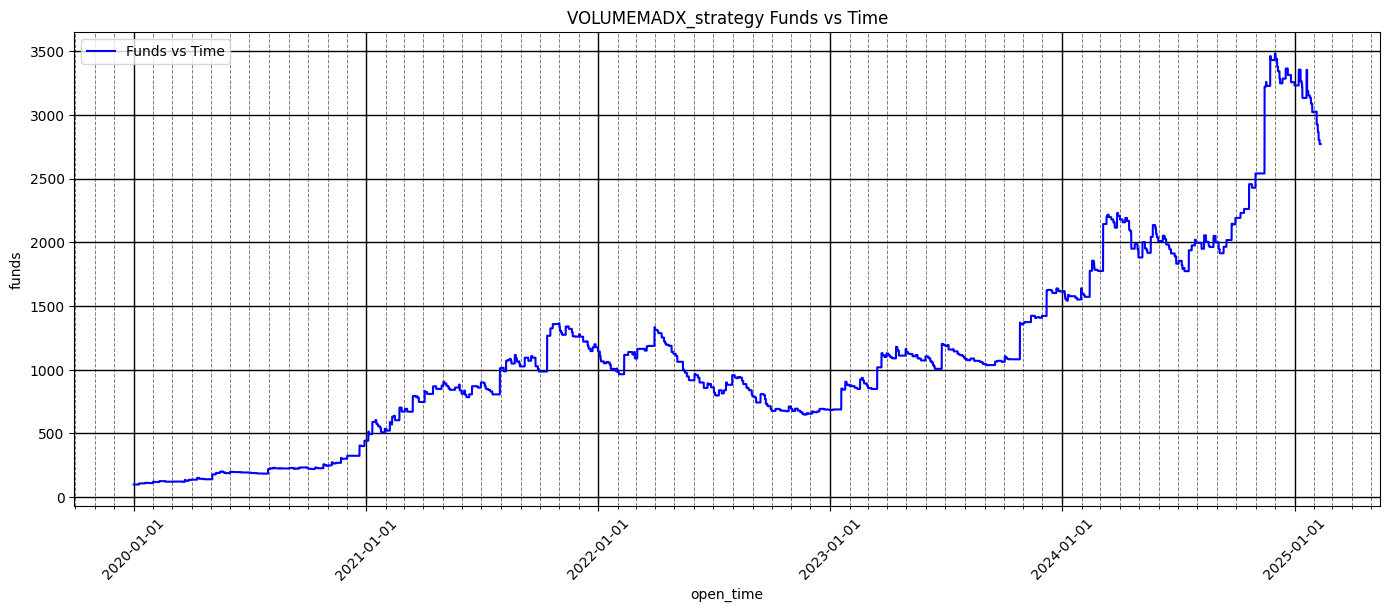

In [2]:
values = {'fast_EMA': 11, 'slow_EMA': 24, 'long_EMA': 193, 'ADX_thresh': np.int64(21), 'ADX_period': 15, 'vol_sma_period': 8}
detailed_backtest(df, VOLUMEMADX_strategy, **values)

In [8]:
# Genetic optimization
# Input values
fast_EMA_range = range(5, 15, 1)
slow_EMA_range = range(15, 31, 1)
long_EMA_range = range(150, 251, 1)
ADX_thresh_range = range(20, 31, 1)
ADX_period_range = range(10, 21, 1)
vol_sma_period_range = range(5, 21, 1)

key_range = {
    'fast_EMA': fast_EMA_range,
    'slow_EMA': slow_EMA_range,
    'long_EMA': long_EMA_range,
    'ADX_thresh': ADX_thresh_range,
    'ADX_period': ADX_period_range,
    'vol_sma_period': vol_sma_period_range
}

def fitness_function(population):
    fitness_values = []
    for individual in population:
        result = backtest(df, VOLUMEMADX_strategy, **individual)
        fitness_values.append(result)
    return fitness_values


# Grid search implementation
optimizer = GeneticOptimizer(
    parameter_ranges=key_range,
    population_size=50,
    elite_size=5,
    mutation_rate=0.2,
    tournament_size=3
)

best_params, best_fitness, fitness_history, diversity_history = optimizer.optimize(
    fitness_function=lambda pop: fitness_function(pop),
    n_generations=50,
    min_diversity=0.3
)

print(f"\nBest parameters: {best_params}")

Restarting population at generation 2591 - Diversity: 0.68
Restarting population at generation 3691 - Diversity: 0.60
Restarting population at generation 4791 - Diversity: 0.64
Generation 50/50 - Best Fitness: 2769.91 - Diversity: 0.72
Best parameters: {'fast_EMA': 11, 'slow_EMA': 24, 'long_EMA': 193, 'ADX_thresh': np.int64(21), 'ADX_period': 15, 'vol_sma_period': 8}


In [ ]:
# Grid search

fast_EMA_range = range(5, 15, 1)
slow_EMA_range = range(15, 31, 1)
long_EMA_range = range(150, 251, 1)
ADX_thresh_range = range(20, 31, 1)
ADX_period_range = range(10, 21, 1)
vol_sma_period_range = range(5, 21, 1)

key_range = {
    'fast_EMA': fast_EMA_range,
    'slow_EMA': slow_EMA_range,
    'long_EMA': long_EMA_range,
    'ADX_thresh': ADX_thresh_range,
    'ADX_period': ADX_period_range,
    'vol_sma_period': vol_sma_period_range
}

fitness_function = backtest

optimizer = GridSearchOptimizer(
    param_ranges=key_range,
    data=df,
    strategy=VOLUMEMADX_strategy
)
result = optimizer.optimize(fitness_function=fitness_function)

Mejor configuración: {'fast_EMA': 13, 'slow_EMA': 21, 'long_EMA': 200, 'ADX_thresh': 20, 'ADX_period': 16, 'vol_sma_period': 15}, Retorno acumulado: 2717.94
